In [2]:
print("coucou")

coucou

In [3]:
using Polyhedra
using JuMP
using LinearAlgebra
using Gurobi #, Cbc, GLPK
using Plots
using LaTeXStrings

In [4]:
include("utils.jl")

getResultsALAP (generic function with 1 method)

In [5]:
# data of the problem
A=[0 1 0; 0 0 1; 1 0 0]
B=[1 0 0; 0 1 0; 0 0 1]
C=[1 0 0; 0 1 0]
k=[0; 0; 0]
N_m=2
N_c=3
T=4

enforceRegular=true

n_y,n_x=size(C)
_,n_u=size(B)

(3, 3)

In [6]:
time_beginning=time_ns()

model,C_bar,S,P_x_all,x_tilde,polEta=instantiateASAP(A,B,C,k,N_m,N_c,T,enforceRegular=enforceRegular);

time_ending=time_ns()
exec_time=(time_ending-time_beginning)/1e9
print("\n\n==== Instantiation time = $(exec_time) seconds ====\n\n")



==== Instantiation time = 46.800270832 seconds ====



In [7]:
set_optimizer(model, Gurobi.Optimizer)

time_beginning=time_ns()

optimize!(model)

time_ending=time_ns()
exec_time=(time_ending-time_beginning)/1e9
print("\n\n==== Solving time = $(exec_time) seconds ====\n\n")

Academic license - for non-commercial use only
Gurobi Optimizer version 9.0.3 build v9.0.3rc0 (mac64)
Optimize a model with 2552 rows, 1497 columns and 6938 nonzeros
Model fingerprint: 0xeb64efa6
Variable types: 1489 continuous, 8 integer (8 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 3e+00]
Presolve removed 2404 rows and 1287 columns
Presolve time: 0.02s
Presolved: 148 rows, 210 columns, 728 nonzeros
Variable types: 210 continuous, 0 integer (0 binary)

Root relaxation: objective 5.000000e+00, 103 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0       5.0000000    5.00000  0.00%     -    0s

Explored 0 nodes (103 simplex iterations) in 0.04 seconds
Thread count was 4 (of 4 available processors)

Solution count 1: 5 

In [8]:
F, f, alpha_opt, sigma_meas_opt, sigma_control_opt=getResultsASAP(model,C_bar,S);
alpha_opt

5.0

In [23]:
"""
for t=0:T-1
    for tau=0:t
        if !sigma_meas_opt[tau+1]
            print("No meas. ")
        else
            print("Meas.    ")
        end
        if !sigma_control_opt[t+1]
            print("No cont. ")
        else
            print("Cont.    ")
        end
        print("f($t)=$(f[:,t+1]) ---  F($t,$(tau))=$(F[:,:,t+1,tau+1]) \n")
    end
end
"""

UndefVarError: UndefVarError: t not defined

In [85]:
x=simulateTrajectories(A,B,C,k,F,f;numberSamples=20);

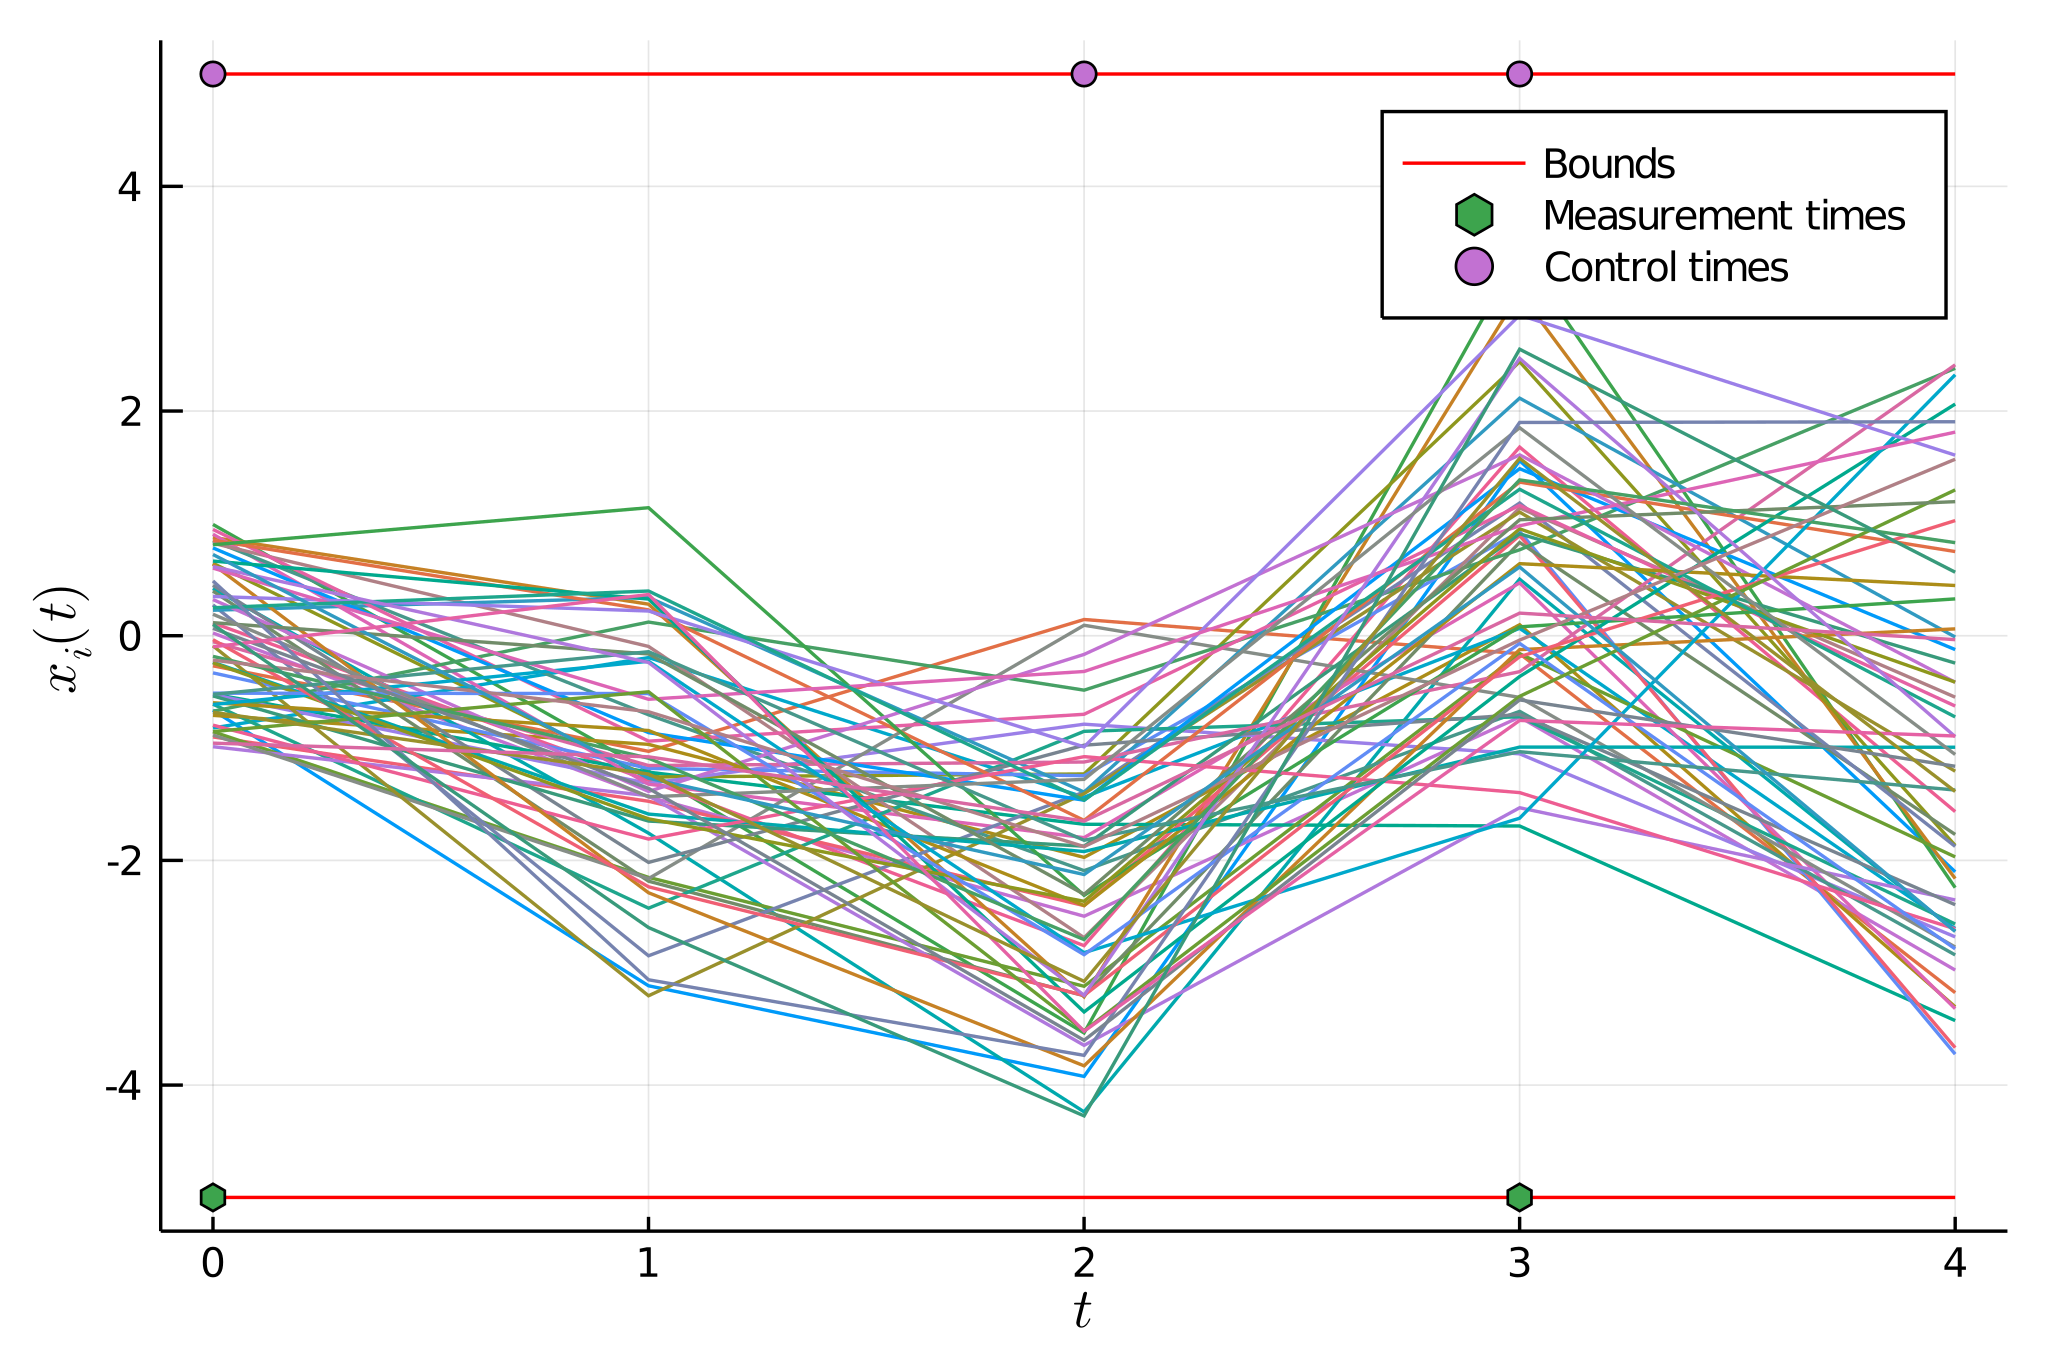

In [86]:
# plot trajectories
plot()
for component=1:size(x)[2]
    plot!(0:T,x[:,component,:]',label=false)
end

xlabel!(L"t")
ylabel!(L"x_i(t)")

plot!(0:T,ones(T+1)*alpha_opt,linecolor=:red, label="Bounds")
plot!(0:T,-ones(T+1)*alpha_opt,linecolor=:red, label=false)

t_meas=findall(sigma_meas_opt.==1).-1
scatter!(t_meas,-alpha_opt*ones(length(t_meas)),label="Measurement times",marker=:hexagon)

t_control=findall(sigma_control_opt.==1).-1
scatter!(t_control,alpha_opt*ones(length(t_control)),label="Control times")
xticks!(0:T)

#plot!(size=(250,250))
savefig("FIGS/ASAP.pdf")
plot!()

In [12]:
# Too slow
#polEta=polyhedron(polEta); # abstract general representation
#Polyhedra.translate(value.(P_x_all)*polEta,value.(x_tilde));